In [7]:
%load_ext autoreload
%autoreload 2

import csv
import time
from collections import deque, Counter

import numpy as np

import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image

from dm_control import mjcf
from dm_control import viewer

import torch
import torch.nn as nn
import torch.nn.init as nn_init
import torch.nn.functional as F
import torch.optim as optim

import gymnasium as gym

from cartpole3d import CartPole3D
from rendering import display_video

from modules.self_normalizing_fnn import SelfNormalizingFNN
from modules.policies.state_model_fnn_policy_2 import StateModelFnnPolicy



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


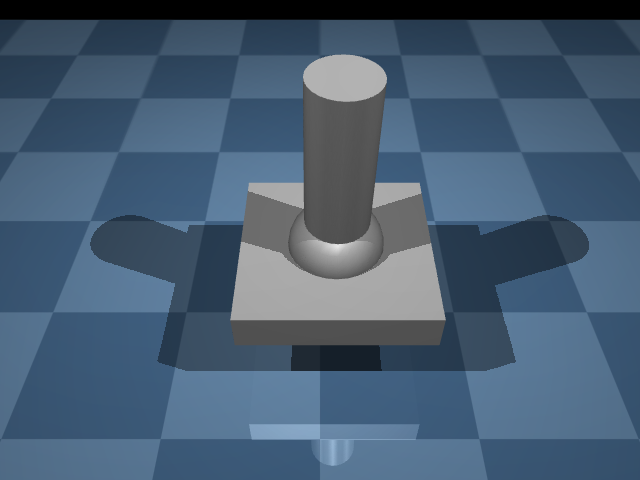

In [2]:
cartpole3d_env = CartPole3D(
    nr_movement_dimensions=2,
    force_magnitude=500,
    physics_steps_per_step=1,
    reset_randomization_magnitude=0.1,
    slide_range=0.5,
    hinge_range=0.8,
    time_limit=3.0,
    step_reward_function=lambda time, action, state, prev_state: 0, # (time if np.any(np.abs(np.array([1.0, 2.0, 4.0, 6.0, 8.0, 10.0]) - time) < 0.002) else 0) + ((-10) if np.linalg.norm(action) > 0.99 else 0), #-np.linalg.norm(state[:4]) + time / 2,
    out_ouf_range_reward_function=lambda time, action, state: -10 + time * 3,
    time_limit_reward_function=lambda time, action, state: 10000,
)

cartpole3d_env.reset()

for _ in range(200):
    cartpole3d_env.step(np.array([0] * cartpole3d_env.nr_movement_dimensions))

cartpole3d_env.render()

In [10]:
device = torch.device('cuda:0' if False and torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

eps = 1e-6

seed = time.time_ns() % (2**32)
np.random.seed(seed)
torch.manual_seed(seed)
print(f'seed is {seed}')

def step_reward(time, action, state, prev_state):
    reward = 0.0

    reward += 0.15
    
    reward += -0.0 * time

    reward += -0.0 * np.linalg.norm(state[0:2])  # slide distance
    reward += -0.0 * np.linalg.norm(state[2:4])  # hinge distance
    
    reward += -0.1 * (np.linalg.norm(state[0:2]) - np.linalg.norm(prev_state[0:2]))
    reward += -1.0 * (np.linalg.norm(state[2:4]) - np.linalg.norm(prev_state[2:4]))
    
    return reward

env = CartPole3D(
    nr_movement_dimensions=2,
    cart_size=0.25,
    force_magnitude=5000,
    physics_steps_per_step=1,
    reset_randomization_magnitude=0.1,
    slide_range=1.5,
    hinge_range=1,
    time_limit=20.0,
    step_reward_function=step_reward,
    out_ouf_range_reward_function=lambda time, action, state: 0,
    time_limit_reward_function=lambda time, action, state: 100,
)
# env = gym.make("CartPole-v1")

action_size = env.action_space.shape[0]
obs_size = env.observation_space.shape[0]


def main():
    saved_actions = []
    saved_log_probs = []
    saved_state_preds = []
    saved_state_targets = []
    rewards = []
    
    action_dist_sd = 0.15
        
    def stringify_np_array(arr):
        return ", ".join([f"{x:> 2.4f}" for x in arr])
    
    def init_policy():
        return StateModelFnnPolicy(
            action_size=action_size,
            state_size=obs_size,
            hidden_sizes=[
                64,
                64,
                64,
                32
            ],
        )    
    
    def select_action(mean_predictions, i_episode):    
        action_dist = torch.distributions.Normal(
            mean_predictions, 
            action_dist_sd # / (1 + i_episode / 30)
        )
        action = action_dist.sample()
        saved_log_probs.append(action_dist.log_prob(action))

        return action.detach().cpu().numpy()
    
    def finish_episode(policy, optimizer):
        R = 0
        policy_loss = []
        returns = deque()
        for r in rewards[::-1]:
            R = r + gamma * R
            returns.appendleft(R)
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)
        
        for log_prob, R in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * R)

        
        optimizer.zero_grad()

        policy_loss = 10.0 * torch.cat(policy_loss).mean()

        if include_state_pred:
            state_pred_loss = 1.0 * F.mse_loss(torch.stack(saved_state_preds), torch.stack(saved_state_targets))
            total_loss = policy_loss + state_pred_loss
        else:
            total_loss = policy_loss
        
        total_loss.backward()
        optimizer.step()
        
        del rewards[:]
        del saved_log_probs[:]
        del saved_state_preds[:]
        del saved_state_targets[:]
        del saved_actions[:]
        
        return returns
        
    print(f'Model has {sum(p.numel() for p in init_policy().parameters() if p.requires_grad)} parameters')

    for gamma in (0.0, 0.5, 0.99):
        for include_state_pred in (True, False):
            with open(f'experiments_logs/cartpole_experiment_{gamma}_{include_state_pred}.csv', mode='w', newline='') as f:
                csv_writer = csv.writer(f, delimiter=',')
                for i_trial in range(100):                    
                    trial_best_timestep = 0
                    
                    policy = init_policy()
                    optimizer = optim.Adam(policy.parameters(), lr=1e-3)
            
                    for i_episode in range(500):
                        state, _ = env.reset()
                        action_pred_log = []
                        info = {}
            
                        for timestep in range(0, 1000000):  # Don't infinite loop while learning
                            action_pred, state_pred = policy.forward(torch.tensor(state).float())
                            
                            action = select_action(action_pred, i_episode)
                            
                            state, reward, done, truncated, info = env.step(action)
            
                            saved_state_preds.append(state_pred)
                            saved_state_targets.append(torch.tensor(state).float())
                            saved_actions.append(action_pred)
                            
                            action_pred_log.append(action_pred.detach().cpu().numpy())
                            rewards.append(reward)
                            
                            if done:
                                break
            
                        if timestep > trial_best_timestep:
                            trial_best_timestep = timestep
            
                        if truncated:
                            break
                
                        finish_episode(policy, optimizer)
    
                    log_entries = [str(gamma), str(include_state_pred), str(trial_best_timestep)]
                    csv_writer.writerow(log_entries)
                    print(', '.join(log_entries))
main()

seed is 996607260
Model has 11306 parameters



KeyboardInterrupt

